In [16]:
import matplotlib.pyplot as plt
import os
import torch
from typing import List
import pandas as pd
import gluonts

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing
import nnts.torch.models
import trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import nnts.pandas
import nnts

torch.set_printoptions(precision=8, sci_mode=False)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
data_path = "data"
model_name = "unrolled-future-covariate-lstm"
base_model_name = "base-lstm"
dataset_name = "tourism"
results_path = "ablation-results"
metadata_path = os.path.join(data_path, f"{base_model_name}-monash.json")
metadata = nnts.data.metadata.load(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.pandas.read_tsf(datafile_path)
params = nnts.models.Hyperparams()
splitter = nnts.pandas.LastHorizonSplitter()

nnts.loggers.makedirs_if_not_exists(PATH)

In [18]:
params.batch_size = 32
params.batches_per_epoch = 50

In [19]:
from dateutil.relativedelta import relativedelta
next_month = df_orig["ds"] + pd.DateOffset(months=1)
df_orig["month"] = next_month.dt.month

In [20]:
import numpy as np

In [21]:
df_orig['unix_timestamp'] = np.log10(2.0 +df_orig.groupby('unique_id').cumcount())


In [22]:
max_min_scaler = nnts.torch.data.preprocessing.MaxMinScaler()
max_min_scaler.fit(df_orig, ["month"])
df_orig = max_min_scaler.transform(df_orig, ["month"])

In [23]:
def prepare_lags(data, lag_seq):
    data = data.copy()
    conts = []
    for lag in range(1, max(lag_seq)):
        data[f"y_lag_{lag}"] = (
            data[["y", "unique_id"]]
            .groupby("unique_id")
            .shift(lag)
        )
        conts.append(f"y_lag_{lag}")
    return data, conts

In [24]:
lag_seq = gluonts.time_feature.lag.get_lags_for_frequency(metadata.freq)
df_orig, lag_conts = prepare_lags(df_orig, lag_seq)
lag_seq = [lag - 1 for lag in lag_seq if lag > 1]

In [25]:
df_orig = df_orig.dropna()

In [26]:
scenario_list: List[nnts.experiments.Scenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.Scenario(
            metadata.prediction_length,
            conts= lag_conts + ["month", "unix_timestamp"],
            seed=seed,
        )
    )

In [27]:
# age = np.log10(2.0 + np.arange(length, dtype=self.dtype))
# length 163

In [28]:
params.training_method = nnts.models.hyperparams.TrainingMethod.TEACHER_FORCING

In [29]:

for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df = df_orig.copy()
    split_data = splitter.split_test_train(df, metadata)
    trn_dl, test_dl = nnts.data.train_test_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    logger = nnts.loggers.LocalFileRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH,
    )
    net = nnts.torch.models.DeepAR(
        nnts.torch.models.LinearModel,
        params,
        nnts.torch.data.preprocessing.masked_mean_abs_scaling,
        1,
        lag_seq=lag_seq,
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        os.path.join(PATH, f"{scenario.name}.pt")
    )
    logger.configure(trner.events)

    evaluator = trner.train(trn_dl)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, trn_dl, metadata
    )
    logger.log(test_metrics)
    print(test_metrics)
    logger.finish()

DeepAR(
  (decoder): UnrolledLSTMDecoder(
    (rnn): LSTM(19, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
)
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-38-pl-24-seed-42.pt
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-38-pl-24-seed-42.pt
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-38-pl-24-seed-42.pt
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-38-pl-24-seed-42.pt
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-38-pl-24-seed-42.pt
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-38-pl-24-seed-42.pt
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-38-pl-24-se

In [215]:
gluon_y_hat = torch.tensor([[196372.62, 165181.3 , 165461.52, 112738.36, 101019.29, 119415.25,
        99374.21, 100394.86, 120971.04, 135340.64, 140176.89, 189092.1 ,
       216439.94, 180999.  , 181581.2 , 134117.25, 113978.02, 128168.54,
       104687.95, 109475.93, 133661.48, 144187.88, 151112.25, 207645.45]])

median_gluon_y_hat = torch.tensor(
    [[194658.28,
                166323.62,
                165344.86,
                114376.87,
                100225.305,
                120307.27,
                99509.57,
                101183.58,
                122892.54,
                135910.06,
                141746.81,
                188034.66,
                215407.0,
                178931.4,
                177086.23,
                132594.23,
                111427.17,
                128356.164,
                103692.95,
                108119.62,
                134489.94,
                142435.2,
                148844.8,
                208224.39,
            ]
    ]
)

In [16]:
test_metrics

{'mse': 69614936.0,
 'abs_error': 17923554.0,
 'abs_target_sum': 156470304.0,
 'abs_target_mean': 17813.103515625,
 'mase': 1.4600043296813965,
 'mape': 0.22291754186153412,
 'smape': 0.2019038200378418,
 'nd': 0.2140747457742691,
 'mae': 2040.4776611328125,
 'rmse': 2624.058837890625}

In [30]:
csv_aggregator = nnts.pandas.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [31]:
results = pd.read_csv(f"{PATH}/results.csv")
results

,input_dim,hidden_dim,n_layers,dropout,output_dim,batch_size,lr,epochs,patience,rnn_type,...,abs_error,abs_target_sum,abs_target_mean,mase,mape,smape,nd,mae,rmse,run_time
0,1,40,2,0.1,1,32,0.001,100,10,lstm,...,17923554.0,156470304.0,17813.103516,1.460004,0.222918,0.201904,0.214075,2040.477661,2624.058838,54.490876
1,1,40,2,0.1,1,32,0.001,100,10,lstm,...,18831816.0,154116992.0,17545.197266,1.518540,0.233502,0.207947,0.223422,2143.877441,2760.660889,54.911580
2,1,40,2,0.1,1,32,0.001,100,10,lstm,...,19406114.0,153861712.0,17516.130859,1.564618,0.235913,0.211108,0.231924,2209.257324,2824.991699,53.219735
3,1,40,2,0.1,1,32,0.001,100,10,lstm,...,19929848.0,152147344.0,17320.960938,1.567099,0.238947,0.212491,0.229060,2268.880371,2901.245605,61.974833
4,1,40,2,0.1,1,32,0.001,100,10,lstm,...,20869418.0,151574304.0,17255.724609,1.526564,0.237018,0.209873,0.225534,2375.844482,3032.879395,54.572923


/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

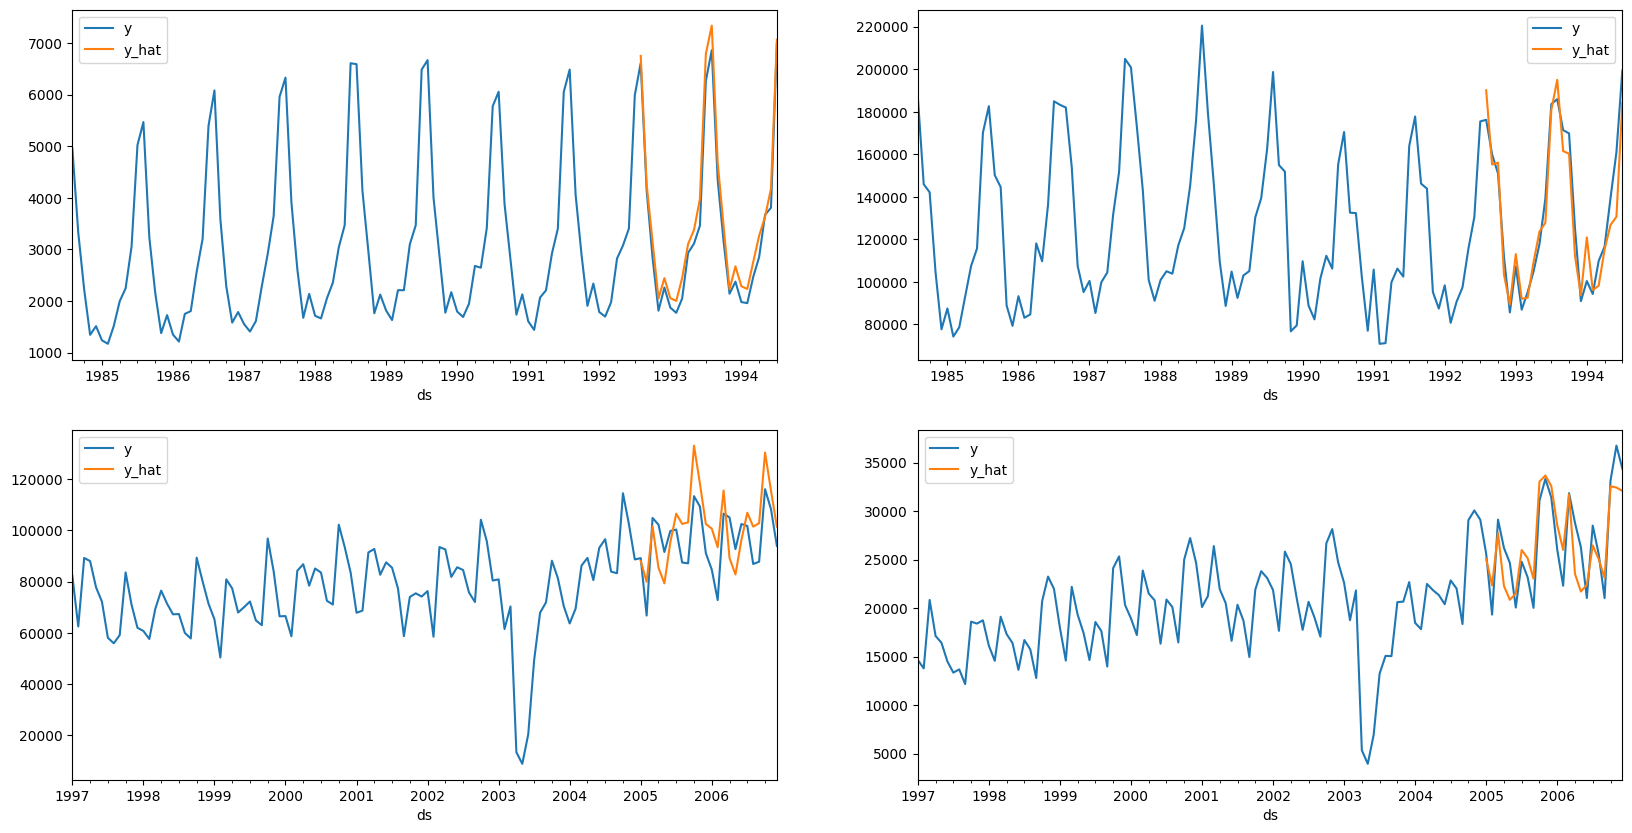

In [144]:
df_list = deepar.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = nnts.experiments.plotting.plot(df_list, scenario.prediction_length)

In [15]:
univariate_results = results.loc[
    (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mape", "rmse", "mae"],
]

univariate_results.mean(), univariate_results.std(), univariate_results.count()

(smape     0.179967
 mape      0.205928
 rmse     25.797200
 mae      21.454759
 dtype: float64,
 smape    0.000553
 mape     0.001968
 rmse     0.326698
 mae      0.273127
 dtype: float64,
 smape    5
 mape     5
 rmse     5
 mae      5
 dtype: int64)

In [ ]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]

In [ ]:
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.4714285714285714, 1.65])),
    cols,
].sort_values(by=['covariates', 'error'])

In [ ]:
sorted(results["error"].unique().tolist())

In [ ]:
import numpy as np
np.linspace(0, 0.6, 8).tolist()